In [10]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.color
import skimage.feature
import sklearn.ensemble
from matplotlib.colors import LinearSegmentedColormap
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from copy import copy, deepcopy

In [11]:
class Img_path:
    def __init__(self, image, path):
        self.image = image
        self.path = path

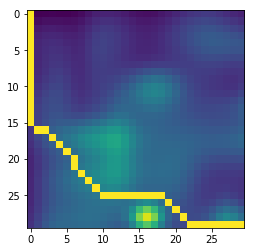

In [12]:
#EX 1a)

def get_files():
    file = h5.File('paths_and_images.h5','r')
    paths_and_images = []
    for key in file:
        paths_and_images.append(Img_path(file[key]['image'][::], file[key]['path'][::1]))
    file.close()
    return paths_and_images

paths_and_images = get_files()
img_with_path = deepcopy(paths_and_images[1].image)
itr = 0
for y in range(img_with_path.shape[0]):
    for x in range(img_with_path.shape[1]):
        if x == paths_and_images[1].path[itr][1] and y == paths_and_images[1].path[itr][0]:
            img_with_path[x][y] = 0.0009 # Path is displayed in yellow in the image
            itr += 1

plt.figure()
plt.imshow(img_with_path)



#EX 1b)
When we are solving for the argmax in order to find the weights shortest path, high penalties should be defined by smaller numbers than low penalties. Thus defining negative penalties in the loss function makes sense.

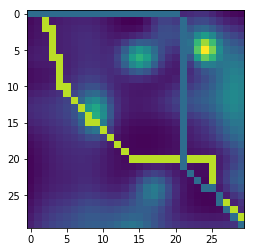

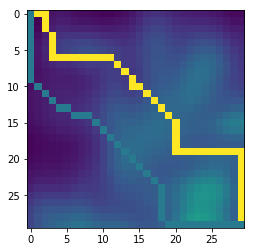

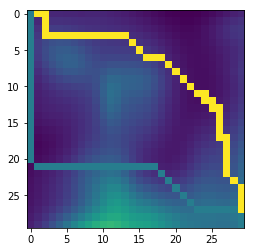

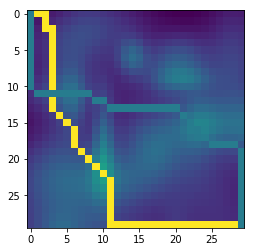

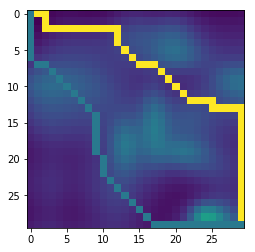

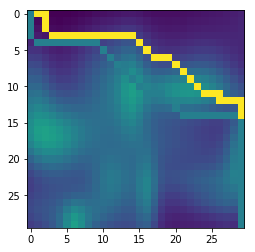

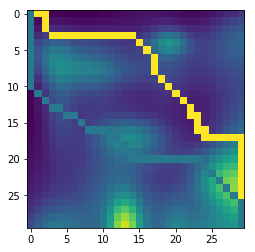

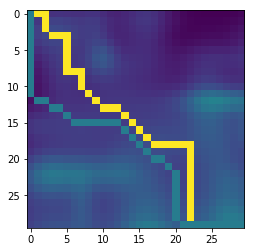

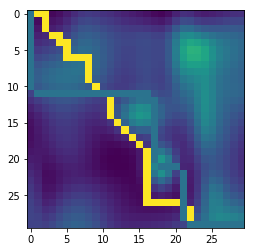

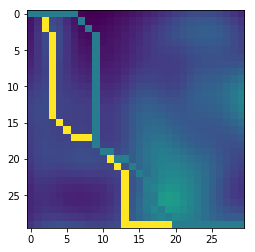

In [13]:
def get_penalty(image, pxl_1, pxl_2):
    # this function calculates the penalty of the movement from pxl_1 to pxl_2
    if pxl_1[0] == -1 or pxl_2[0] == -1:
        return 0
    
    gray_val_1 = image[int(pxl_1[1])][int(pxl_1[0])]
    gray_val_2 = image[int(pxl_2[1])][int(pxl_2[0])]
    
    a = np.sqrt(np.power(pxl_1[1]-pxl_2[1], 2)+np.power(pxl_1[0]-pxl_2[0], 2))
    b = np.absolute(gray_val_1-gray_val_2)
    
    # not sure if taking the maximum or the sum here. The sum gives a nicer solution though
    return np.sum([-a, -np.power(a,2), -b, -np.power(b, 2), -np.power(b, 3)])
    #return np.amax([-a, -np.power(a,2), -b, -np.power(b, 2), -np.power(b, 3)])

def init_paths(image, paths, penalties, w, b):
    # the initializing is done on order to have for each beam one path that can be continued with.
    # Beginning with pixel [0 0] there are only 3 possible paths. 
    # With a beam-number of 100 all paths have the same start which is calculated in this function.
    paths.append([])
    paths[0].append([0, 0])
    penalties.append(0)
    
    if len(paths) == b:
                return
    
    while True:  # go through all paths in the list and extend the list with the new paths. 
                 # Keep also track of the penalties
        for i in range(len(paths)+1):
            tmp_path = deepcopy(paths[i])
            tmp_penalty = deepcopy(penalties[i])
            c_pixel = paths[i][len(paths[i])-1]
            n_pixel = [c_pixel[0], c_pixel[1]+1]
            paths[i].append(n_pixel)
            penalties[i] += w[i] * get_penalty(image, c_pixel, n_pixel)
            
            n_pixel = [c_pixel[0]+1, c_pixel[1]]
            paths.append([])
            paths[len(paths)-1].extend(tmp_path)
            paths[len(paths)-1].append(n_pixel)
            penalties.append(tmp_penalty + w[i] * get_penalty(image, c_pixel, n_pixel))
            if len(paths) == b:
                return
            
            n_pixel = [c_pixel[0]+1, c_pixel[1]+1]
            paths.append([])
            paths[len(paths)-1].extend(tmp_path)
            paths[len(paths)-1].append(n_pixel)
            penalties.append(tmp_penalty + w[i] * get_penalty(image, c_pixel, n_pixel))
            if len(paths) == b:
                return
            
def update_w(training_path, training_image, w, y_roof):
    # Pad both paths to the same lenght. The pixel [-1, -1] indicates that the path has finished
    # also post 0-pad w to that lenght
    max_len = np.maximum(len(training_path), len(y_roof))
    for i in range(max_len-len(training_path)):
        training_path.append([])
        training_path[len(training_path)-1] = [-1, -1]     # indicator that the path has finished
    for i in range(max_len-len(y_roof)):
        y_roof.append([])
        y_roof[len(y_roof)-1] = [-1, -1]     # indicator that the path has finished
    for i in range(max_len-len(w)):
        w.append(0)
    
    for i in range(max_len-1):
        if not(np.array_equal(y_roof[i+1], training_path[i+1])):
            w[i] += (get_penalty(training_image, training_path[i], training_path[i+1]) 
                    - get_penalty(training_image, y_roof[i], y_roof[i+1]))

def get_y_roof(image, y_init, penalties, w):
    # return the path that was evalueated the cheapest under all beams.
    # y_init is expected to contain one path per beam, starting with [0 0]
    for p in range(len(y_init)):
        while not(np.array_equal(y_init[p][len(y_init[p])-1], [29, 29])):
            c_pixel = y_init[p][len(y_init[p])-1]
            if c_pixel[0] == 29:
                n_pixel = [c_pixel[0], c_pixel[1]+1]
                y_init[p].append(n_pixel)
                penalties[p] += w[len(y_init[p])-1] * get_penalty(image, c_pixel, n_pixel)
            elif c_pixel[1] == 29:
                n_pixel = [c_pixel[0]+1, c_pixel[1]]
                y_init[p].append(n_pixel)
                penalties[p] += w[len(y_init[p])-1] * get_penalty(image, c_pixel, n_pixel)
            else:
                c_w = w[len(y_init[p])-1]
                n_pixel = [[c_pixel[0], c_pixel[1]+1],
                           [c_pixel[0]+1, c_pixel[1]],
                           [c_pixel[0]+1, c_pixel[1]+1]]
                pen = [c_w*get_penalty(image, c_pixel, n_pixel[0]),
                       c_w*get_penalty(image, c_pixel, n_pixel[1]),
                       c_w*get_penalty(image, c_pixel, n_pixel[2])]
                cheapest = np.argmax(pen)
                
                y_init[p].append(n_pixel[cheapest])
                penalties[p] += pen[cheapest]
                           
    return y_init[np.argmax(penalties)]
            
def run_beamSearch_training(paths_and_images, w, b):
    # apply the beam search on the training set and continuously update w
    paths = []
    penalties = []
    y_roof = []
    y_roof_last = []
    for i in range(paths_and_images[0].image.shape[0]):
        y_roof.append([])
        y_roof[i] = [i, i]
    
    update_w(paths_and_images[0].path, paths_and_images[0].image, w, y_roof)
    
    for i in range(1, len(paths_and_images)):
        paths = []
        penalties = []
        y_roof = []
        training_path = paths_and_images[i].path.tolist()
        training_image = paths_and_images[i].image
        init_paths(training_image, paths, penalties, w, b)
        y_roof = get_y_roof(training_image, paths, penalties, w)
        update_w(training_path, training_image, w, y_roof)
    
def run_beamSearch_test(images, w, b):
    # apply the beam search with the w which was obtained from the training on the training set
    y_roof = []
    for i in range(len(images)):
        paths = []
        penalties = []
        y_roof.append([])
        test_image = images[i].image
        init_paths(test_image, paths, penalties, w, b)   
        y_roof[i] = get_y_roof(test_image, paths, penalties, w)
        
    return y_roof

def visualize_images_and_paths(image, pred_path, real_path):
    # visualize one image with the predicted path from the beam search 
    # algorithm and the real path from the loaded dataset
    paths_and_images = get_files()
    img_with_path = deepcopy(image)
    itr_1 = 0
    itr_2 = 0
    for y in range(img_with_path.shape[0]):
        for x in range(img_with_path.shape[1]):
            if x == pred_path[itr_1][1] and y == pred_path[itr_1][0]:
                img_with_path[x][y] = 0.0009 # Path is displayed in yellow in the image
                itr_1 += 1
            if x == real_path[itr_2][1] and y == real_path[itr_2][0]:
                img_with_path[x][y] = 0.0004 # Path is displayed in green in the image
                itr_2 += 1

    plt.figure()
    plt.imshow(img_with_path)

#EX 1c)    
w = [0] * 100  # make sure w is large enough, meaning at least as large as the longest path
b = 100        # a beam number of 100 certainly takes a while´but improves the solution
files = get_files()
training_files = files[0:len(files)-11]
test_files = files[len(files)-11:len(files)-1]
run_beamSearch_training(training_files, w, b)
#EX 1d)
resulting_paths = run_beamSearch_test(test_files, w, b)
for i in range(len(resulting_paths)):
    visualize_images_and_paths(test_files[i].image, resulting_paths[i], test_files[i].path)
    